# New model structure functions

Test out the adjustments to the structure function model that account for the finite box effect. 

## The model itself

The structure function is written in terms of the spatial autocorrelation 
$$
B(r) = 2 \sigma^2 \left( 1 - C \right)
$$
where the spatial autocorrelation (normalized autocovariance) is modeled as 
$$
C(r) = \exp \left[ -\ln 2 \, \left( \frac{r}{r_0} \right)^m \right]
$$
where $r_0$ is the coherence length and $m$ is the power law slope at small scales. 
This replaces the model we had previously:
$$
C(r) = \left[ 1 + \left( \frac{r}{r_0} \right)^m \right]^{-1}
$$
The advantage of the exponential version is that it makes a shaper transition from the power law growth to the flat portion. 

Note that the model autocorrelation is always positive, whereas in principle it could go between $[-1, 1]$. Negative autocorrelation can be produced by periodic fluctuations of wavelength $\lambda$ – negative peaks occur at $r = \lambda/2, 3\lambda/2, \dots$. 

The integral scale of the turbulence is given by $r_\mathrm{int} = \xi(m) r_0$ where
$$
\xi(m) = \frac{ 1} { m \, (\ln 2)^{1/m}} \, \Gamma\left(\frac{1}{m}\right) \sim 1.5
$$
The $\xi$ factor falls from 2.3 to 1.1 as $m$ rises from $2/3$ to $5/3$. 

In [3]:
def bfunc00s(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = np.exp(-np.log(2) * (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

The seeing is the empirical function that we fitted to the fake data.  After some manipulation, we can reduce the fitting function to:
$$
S(r; s_0, r_0) = 
\frac{ e^{-s_0 / r_0} }
{1 + (2 s_0 / r)^a}
$$
with $a = 3/2$ yielding the best fit.

In [4]:
def seeing_large_scale(s0, r0):
    return np.exp(-s0 / r0) 

def seeing_empirical(r, s0, r0, a=1.5):
    """
    Simplified version of empirical fit to B(r) reduction from seeing
    """
    return seeing_large_scale(s0, r0) / (1 + (2 * s0 / r)**a)




In [5]:
def bfunc03s(r, r0, sig2, m, s0, noise):
    "Structure function with better seeing (scale `s0`) and noise"
    return seeing_empirical(r, s0, r0) * bfunc00s(r, r0, sig2, m) + noise

Finally, we have the finite-box effect, which depends on the box size $L$ relative to the correlation length:

In [6]:
def finite_box_effect(r0, L, scale=3.6):
    return 1 - np.exp(-L / (scale * r0))

def bfunc04s(r, r0, sig2, m, s0, noise, box_size):
    "Structure function with better seeing (scale `s0`) and noise, plus finite box effect"
    boxeff = finite_box_effect(r0, box_size)
    return seeing_empirical(r, s0, r0) * bfunc00s(r, boxeff*r0, boxeff*sig2, m) + noise

# Example structure functions

In [7]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

Compare true and apparent structure functions:

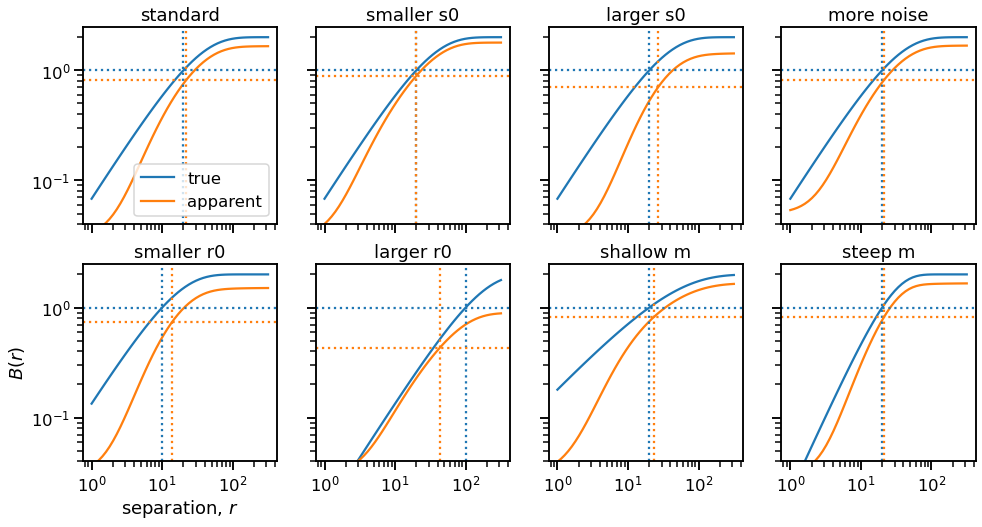

In [8]:
fig, axes = plt.subplots(
    2, 4, 
    sharex=True, sharey=True,
    figsize=(16, 8),
)
r = np.logspace(0.0, 2.5)
box_size = 212.0
sig2 = 1.0

for (r0, s0, m, noise, label), ax in zip([
        [20.0, 3.0, 1.0, 0.03, "standard"],
        [20.0, 1.5, 1.0, 0.03, "smaller s0"],
        [20.0, 6.0, 1.0, 0.03, "larger s0"],
        [20.0, 3.0, 1.0, 0.05, "more noise"],
        [10.0, 3.0, 1.0, 0.03, "smaller r0"],
        [100.0, 3.0, 1.0, 0.03, "larger r0"],
        [20.0, 3.0, 0.667, 0.03, "shallow m"],
        [20.0, 3.0, 1.4, 0.03, "steep m"],
], axes.flat):
    true_b = ax.plot(
        r, bfunc00s(r, r0, sig2, m),
        label="true",
    )
    c_true = true_b[0].get_color()
    app_b = ax.plot(
        r, 
        bfunc04s(r, r0, sig2, m, s0, noise, box_size),
        label="apparent",
    )
    c_app = app_b[0].get_color()
    
    ax.axhline(sig2, color=c_true, linestyle="dotted")
    ax.axvline(r0, color=c_true, linestyle="dotted")
    
    
    sig2_app = finite_box_effect(r0, box_size) * seeing_large_scale(s0, r0) * sig2
    rr, bb = app_b[0].get_data()
    r0_app = np.interp(sig2_app, bb, rr)
    
    ax.axhline(sig2_app, color=c_app, linestyle="dotted")
    ax.axvline(r0_app, color=c_app, linestyle="dotted")
    ax.set_title(label)
axes[0, 0].legend()             
axes[-1, 0].set(
    xscale="log",
    yscale="log",
    ylim=[0.04, 2.5],
    xlabel=r"separation, $r$",
    ylabel=r"$B(r)$",
);

The "true" curve (blue) is the basic model without any instrumental effects.  The "apparent" curve includes the effects of seeing, noise, and finite box.  The true and apparent $r_0$ and $\sigma^2$ are shown by dotted lines.  The $\sigma^2$ is reduced by both effects, but $r_0$ can be increased by seeing or reduced by finite-box.

## Apply to real data

Eventually, we need to repeat the lmfit fits.  But for the moment, I will just tune the parameters by hand to get something that fits OK. 

_Actually, it might be worth trying to use `linmix` to do these fits. No - can't do that since linmix is only for fitting straight lines, but we could look at some of the [mcmc extensions of lmfit](https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html)._

### Orion

In [9]:
import json

In [10]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

In [122]:
with open("orion-strucfunc-ha.json") as f:
    sf = values2arrays(json.load(f))

In [123]:
mask = sf["N pairs"] > 0

In [124]:
import astropy.units as u

In [125]:
Distance_pc = 410
pix_scale_arcsec = 0.534
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec
pix_scale_pc

0.0010614510734212183

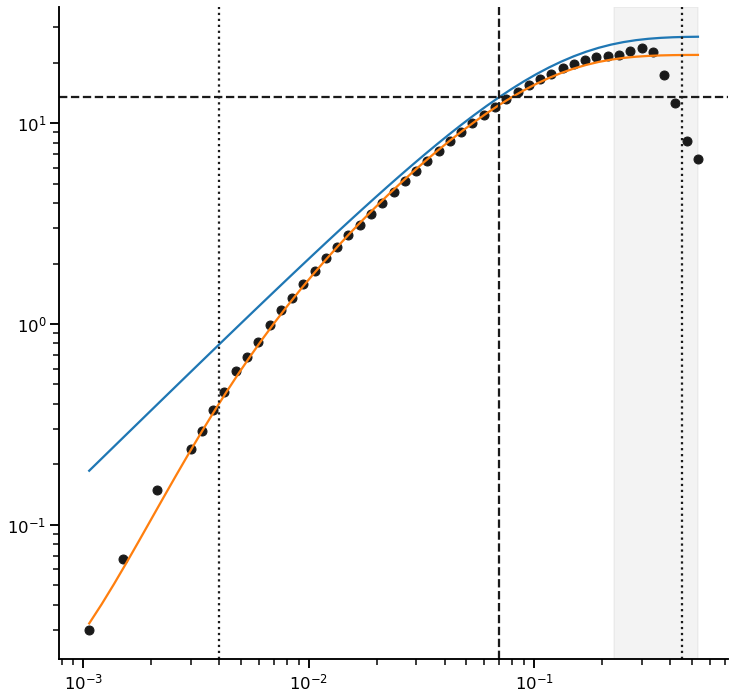

In [126]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = np.sqrt(356 * 512) * pix_scale_pc
s0 = 1.0 * pc_per_arcsec
r0 = 0.07
m = 1.1
sig2 = 13.5
noise = 0.01

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

Blue line is the theoretical structure function, while orange line is the preficted observed one, taking into account the instrumental effects. 

Dashed lines show the "true" $r_0$ and $\sigma^2$.  Dotted lines show $2 s_0$ to left and $L$ to right.  The shaded area shows $r > L/2$ where large-scale gradients and periodicity will be important. 

For Orion the finite-box effect is very small but the effect of seeing is quite important. 

### NGC 346

In [159]:
with open("ngc346-strucfunc-ha.json") as f:
    sf = values2arrays(json.load(f))
mask = sf["N pairs"] > 0

In [160]:
Distance_pc = 61700
pix_scale_arcsec = 0.2
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec
pix_scale_pc

0.05982600824891674

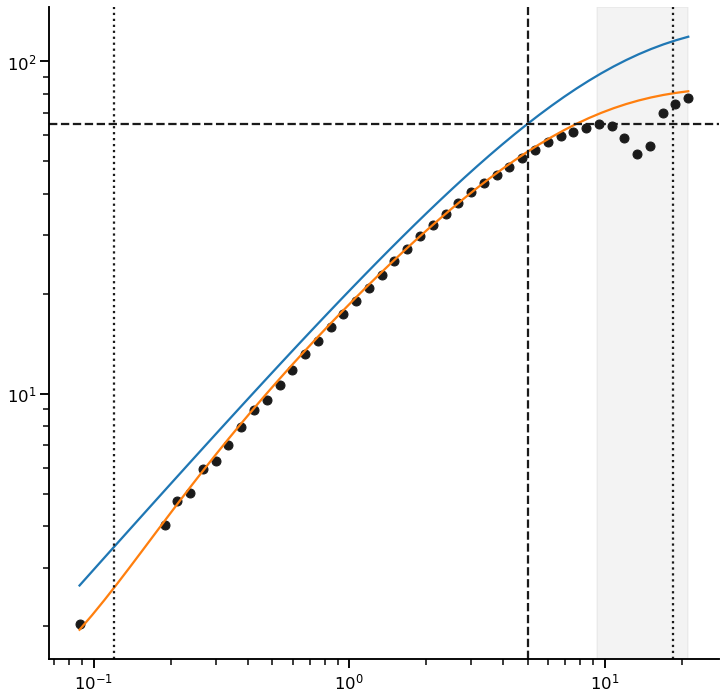

In [161]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]

# Merge first K points
K = 3
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = np.sqrt(316 * 305) * pix_scale_pc
s0 = 0.2 * pc_per_arcsec
r0 = 5.0
m = 0.87
sig2 = 65
noise = 1.0

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

So, for NGC 346 we have a smaller seeing effect than with Orion, but we do have a more significant finite box effect with $L / r_0$ of about 3.8. The resultant $\sigma^2$ is about twice what we would naively obtain from the data. 

There is a degeneracy between $r_0$ and $\sigma^2$ that needs to be explored with the fits.

### 30 Dor

In [162]:
with open("tarantula-strucfunc-ha.json") as f:
    sf = values2arrays(json.load(f))
mask = sf["N pairs"] > 0

In [163]:
Distance_pc = 50000
pix_scale_arcsec = 0.2
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec
pix_scale_pc

0.048481368110953604

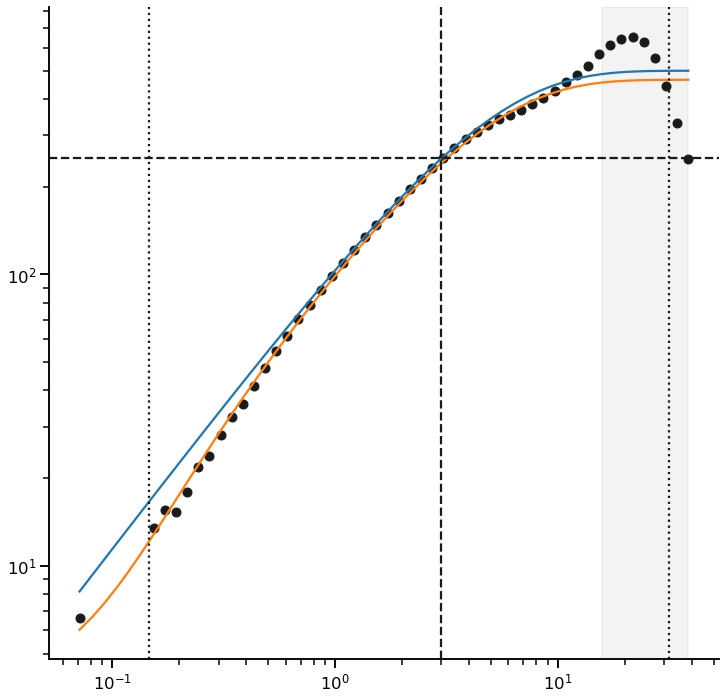

In [164]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]

# Merge first K points
K = 3
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = 650 * pix_scale_pc
s0 = 0.3 * pc_per_arcsec
r0 = 3.0
m = 1.0
sig2 = 250
noise = 4.0

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

For 30 Dor, the instrumental effects at both ends (seeing and finite-box) are quite small. On the other hand, there is a large deviation at scales of about 2 pixels, which must be due to the pattern noise. 

What we could do there is to merge the first 3 points, or just the first 2. And then it would be well-fit with the noise term. 

### NGC 604

We will use Javier's structure functions for the distant sources

In [172]:
import pickle
from pathlib import Path

jav_path = Path("../JavierGVastro/PhD.Paper/")

In [172]:
with open(jav_path / "SFresults" / "N604H.pkl", "rb") as f:
    sfdata = pickle.load(f)
with open(jav_path / "VFM" / "N604H.pkl", "rb") as f:
    vfdata = pickle.load(f)

sf = sfdata["SF"]
sf

{'log10 r': array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 ]),
 'Sum dv^2': array([1.49356386e+04, 6.09917689e+04, 2.80081093e+05, 1.13203703e+06,
        4.20099085e+06, 1.21583612e+07, 3.56158287e+07, 8.10123968e+07,
        1.71353210e+08, 3.74928611e+08, 8.25639149e+08, 1.38362516e+09,
        1.34257490e+09, 5.90399199e+08, 9.24450296e+07]),
 'Sum weights': array([   850.88800401,   1695.25138799,   4196.71801893,   9044.56481783,
         19016.50862421,  34334.60854121,  67937.79524796, 114347.93074012,
        193783.41107865, 311025.23825202, 498773.16060561, 724762.15961093,
        737858.38854927, 363919.29898594,  68101.13034801]),
 'Sum w * dv^2': array([1.21492162e+03, 4.69687762e+03, 2.31069926e+04, 9.66356182e+04,
        3.72369233e+05, 1.11869575e+06, 3.38412169e+06, 7.63870396e+06,
        1.45259484e+07, 2.59451701e+07, 5.28126096e+07, 7.70788022e+07,
        6.51217579e+07, 2.71122363e+07, 3.30402972e+06]),
 

In [181]:
vfdata["vv"].shape

(151, 145)

In [176]:
Distance_pc = 840_000
pix_scale_arcsec = vfdata["pix"]
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec
pix_scale_pc

1.0588330795432266

In [179]:
pix_scale_arcsec, pc_per_arcsec

(0.26, 4.072434921320102)

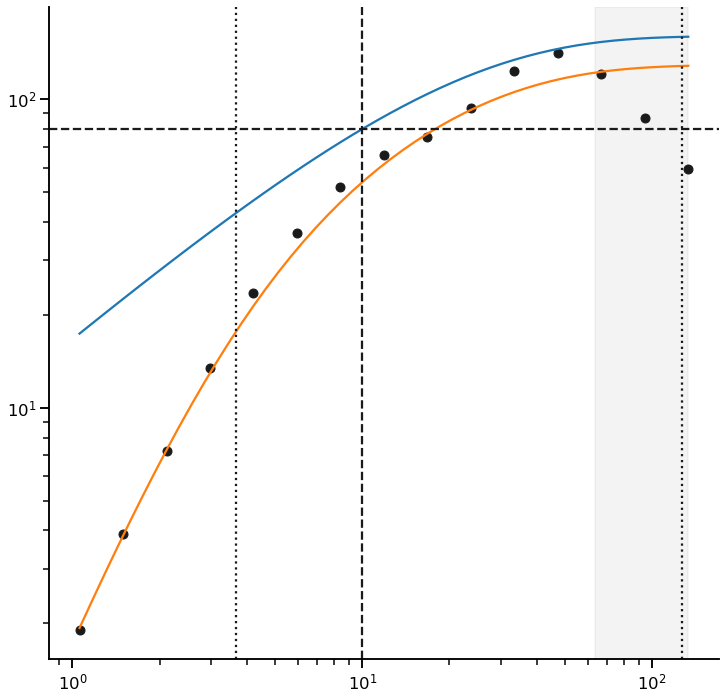

In [197]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"]
r *= pix_scale_pc
B = sf["Unweighted B(r)"]

# Merge first K points
# K = 3
# r[K] = np.mean(r[:K])
# B[K] = np.mean(B[:K])
# r = r[K:]
# B = B[K:]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = 120 * pix_scale_pc
s0 = 0.45 * pc_per_arcsec
r0 = 10.0
m = 0.8
sig2 = 80
noise = 0.0

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

In NGC 604 it is the seeing that is the most important effect.  The finite-box effect does absolutely nothing, which is expected since the observed field covers the entire object. 

_It would be better if the structure function were more finely sampled - use `dlogr=0.05`_


### NGC 595 

In [198]:
with open(jav_path / "SFresults" / "N595.pkl", "rb") as f:
    sfdata = pickle.load(f)
with open(jav_path / "VFM" / "N595.pkl", "rb") as f:
    vfdata = pickle.load(f)

sf = sfdata["SF"]
sf

{'log10 r': array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25]),
 'Sum dv^2': array([1.68869228e+04, 6.08004392e+04, 2.54084440e+05, 9.14193369e+05,
        3.06280407e+06, 8.08034721e+06, 2.36776266e+07, 6.06188347e+07,
        1.51064218e+08, 3.16745818e+08, 5.39609535e+08, 7.94679509e+08,
        7.99491742e+08, 4.90122286e+08, 1.74920332e+08, 4.65031435e+06]),
 'Sum weights': array([   591.38213314,   1176.73082279,   2909.67033363,   6268.50492025,
         13163.03812235,  23708.13348828,  46693.48989943,  77444.97762969,
        126543.53734215, 190403.76196768, 296989.73322169, 436721.35396209,
        382702.20624017, 174881.53757773,  59182.0371229 ,   1139.75493308]),
 'Sum w * dv^2': array([9.36495151e+02, 3.67353438e+03, 1.62991034e+04, 6.27489770e+04,
        2.19322941e+05, 5.84246181e+05, 1.62073853e+06, 3.69028061e+06,
        8.04795684e+06, 1.46186311e+07, 2.46042516e+07, 3.44128113e+07,
        2.39548195e+

In [200]:
vfdata["vv"].shape

(166, 207)

In [199]:
Distance_pc = 840_000
pix_scale_arcsec = vfdata["pix"]
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec
pix_scale_pc

1.0588330795432266

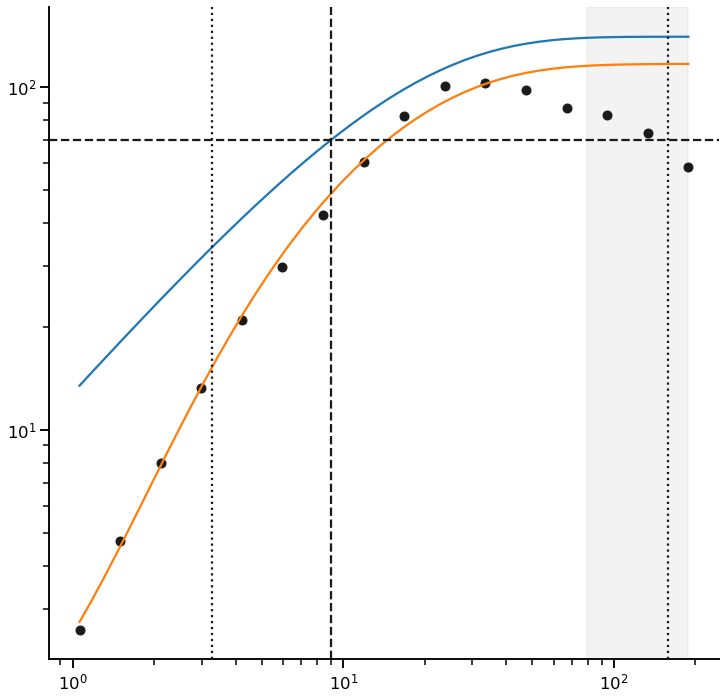

In [208]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"]
r *= pix_scale_pc
B = sf["Unweighted B(r)"]

# Merge first K points
# K = 3
# r[K] = np.mean(r[:K])
# B[K] = np.mean(B[:K])
# r = r[K:]
# B = B[K:]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = 150 * pix_scale_pc
s0 = 0.4 * pc_per_arcsec
r0 = 9.0
m = 0.9
sig2 = 70
noise = 1.0

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

NGC 595 is another one that is dominated by seeing.  

Is it possible that the true spectrum is flat and that the entire downturn is due to the seeing?
Let's do an experiment:


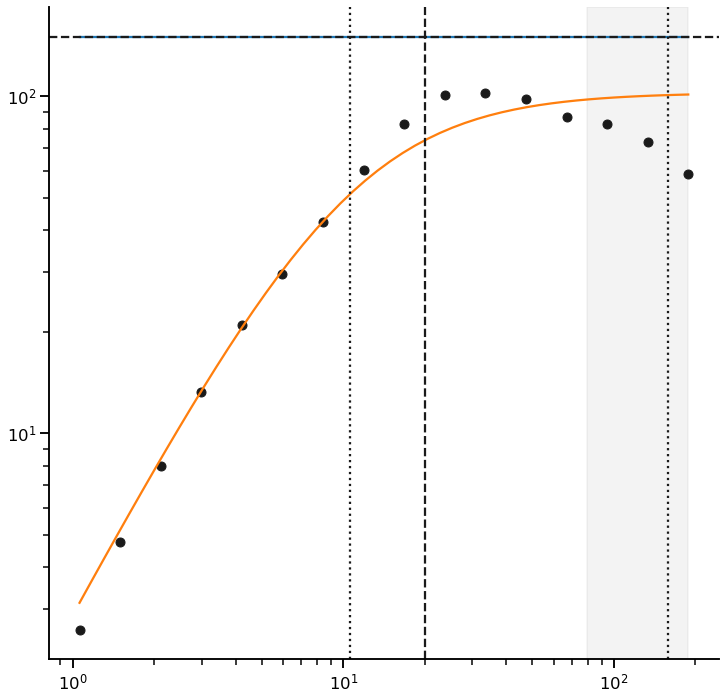

In [220]:
fig, ax = plt.subplots(figsize=(12, 12))


r = 10**sf["log10 r"]
r *= pix_scale_pc
B = sf["Unweighted B(r)"]

# Merge first K points
# K = 3
# r[K] = np.mean(r[:K])
# B[K] = np.mean(B[:K])
# r = r[K:]
# B = B[K:]

# Observed strucfunc
ax.plot(r, B, linestyle="none", marker="o", color="k")

# Model parameters
L = 150 * pix_scale_pc
s0 = 1.3 * pc_per_arcsec
r0 = 20.0
m = 0.0
sig2 = 150
noise = 0.0

# Model strucfunc
rgrid = np.logspace(np.log10(r[0]), np.log10(r[-1]))

true_b = ax.plot(
    rgrid, bfunc00s(rgrid, r0, sig2, m),
    label="true",
)
c_true = true_b[0].get_color()
app_b = ax.plot(
    rgrid, 
    bfunc04s(rgrid, r0, sig2, m, s0, noise, L),
    label="apparent",
)
c_app = app_b[0].get_color()


ax.axvline(L, color="k", linestyle="dotted")
ax.axvline(2 * s0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dashed")
ax.axhline(sig2, color="k", linestyle="dashed")
ax.axvspan(L/2, r[-1], color="k", alpha=0.05, zorder=-1)
ax.set(
    xscale="log",
    yscale="log",
)
sns.despine();

So the answer is "yes", but we have to use an unrealistically large seeing: $s_0 = 1.3$ arcsec, so FWHM of 3 arcsec. So, this means that the true structure function cannot be flat.